I simply changed the Cross Entropy by BCE with logit loss

This allows for multi-class. However, may not be ideal for predicting uncommon classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm

In [2]:
REGIONS_BUCKETS = {'europe': ['europe','denmark-1','denmark-2'],
                   'east-africa':['east-africa','tanzania-1','tanzania-2','tanzania-3','tanzania-4','tanzania-5','uganda-1'],
                   'northwest-africa':['eq-guinea','ghana-1','egypt-1','isreal-1','isreal-2','nigeria','senegal'],
                   'north-america':['north-america'],
                   'south-america':['south-america'],
                   'japan':['japan']}


In [92]:
patches_folder = "/home/ccollado/phileo_phisat2/L1C/np_patches_128_cropped"
train_files = [f for f in os.listdir(patches_folder) if f.endswith("train_label_lc.npy")]
europe_train_files = [f for f in train_files if any([region in f for region in REGIONS_BUCKETS['europe']])]
unique_keys = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]


In [93]:
df_counts = pd.DataFrame(index=unique_keys, columns=REGIONS_BUCKETS.keys(), data=0.0)
df_proportions = df_counts.copy()

for region, region_files in REGIONS_BUCKETS.items():
    print(f"Processing region: {region}")
    # Filter train files for the current region
    region_train_files = [f for f in train_files if any([region in f for region in region_files])]
    num_files = 0

    # Process each file in the current region
    for file in tqdm(region_train_files):
        arr = np.load(os.path.join(patches_folder, file))
        num_files += arr.shape[0]
        present_keys = [sum(1 for i in range(arr.shape[0]) if key in arr[i]) for key in unique_keys]
        df_counts.loc[:, region] += present_keys

    df_proportions.loc[:, region] = df_counts.loc[:, region] / num_files

Processing region: europe


100%|██████████| 161/161 [00:00<00:00, 260.79it/s]


Processing region: east-africa


100%|██████████| 225/225 [00:07<00:00, 29.28it/s]


Processing region: northwest-africa


100%|██████████| 355/355 [00:07<00:00, 49.19it/s]


Processing region: north-america


100%|██████████| 62/62 [00:01<00:00, 42.12it/s]


Processing region: south-america


100%|██████████| 78/78 [00:01<00:00, 40.64it/s]


Processing region: japan


100%|██████████| 31/31 [00:00<00:00, 51.06it/s]


In [94]:
df_proportions

,europe,east-africa,northwest-africa,north-america,south-america,japan
10,0.746012,0.854841,0.655800,0.838482,0.873825,0.851811
20,0.017207,0.917982,0.811546,0.171274,0.316348,0.000000
30,0.813587,0.933373,0.913679,0.813550,0.814983,0.608123
40,0.541674,0.828927,0.689375,0.222222,0.219594,0.504940
50,0.501882,0.578269,0.334777,0.530623,0.370337,0.407245
60,0.124574,0.227901,0.226687,0.406504,0.282681,0.198683
70,0.020792,0.000000,0.000000,0.000000,0.000000,0.000000
80,0.415487,0.046961,0.090978,0.256911,0.265999,0.254665
90,0.165442,0.075901,0.078306,0.076965,0.113436,0.037322
95,0.000000,0.000855,0.011372,0.021680,0.020322,0.000000


In [11]:
df_counts.to_csv("counts_by_region.csv")
df_proportions.to_csv("proportions_by_region.csv")

In [12]:
df_counts = pd.read_csv("counts_by_region.csv", index_col=0)
df_counts['europe']

10     70550.0
20      1443.0
30     76088.0
40     49178.0
50     42043.0
60      9539.0
70      1844.0
80     52736.0
90     14297.0
95         0.0
100     6897.0
Name: europe, dtype: float64

In [11]:
df_proportions = pd.read_csv("proportions_by_region.csv", index_col=0)
df_proportions

,europe,east-africa,northwest-africa,north-america,south-america,japan
10,0.648855,0.804432,0.557173,0.730714,0.820688,0.626112
20,0.013271,0.878918,0.748600,0.232399,0.269052,0.000113
30,0.699788,0.880432,0.845139,0.730013,0.731161,0.365443
40,0.452295,0.715842,0.673682,0.228498,0.180196,0.247172
50,0.386673,0.379115,0.241348,0.351259,0.221172,0.147640
60,0.087731,0.125112,0.176797,0.313710,0.163098,0.068165
70,0.016959,0.000000,0.000000,0.000000,0.000000,0.000000
80,0.485018,0.071864,0.111725,0.282712,0.254164,0.419281
90,0.131491,0.076411,0.055611,0.077542,0.092940,0.011688
95,0.000000,0.001152,0.017466,0.017497,0.018911,0.000075


# Balancing Techniques

## ML-ROS

In [4]:
# -*- coding: utf-8 -*-
# @Author  : Light--

"""
Description：use ml-ros to balance celeba train set
Similar repo: https://github.com/wtomin/Multitask-Emotion-Recognition-with-Incomplete-Labels/blob/0cedf4ca8e117fe5f2950d58af67c1e4cc831f95/create_annotation_file/DISFA/create_annotation_Mixed_AU.py
"""
import numpy as np
import time

def IRLbl(labels):
    # imbalance ratio per label
    # Args:
    #	 labels is a 2d numpy array, each row is one instance, each column is one class; the array contains (0, 1) only
    N, C = labels.shape
    pos_nums_per_label = np.sum(labels, axis=0)
    max_pos_nums = np.max(pos_nums_per_label)
    return max_pos_nums / pos_nums_per_label

def MeanIR(labels):
    IRLbl_VALUE = IRLbl(labels)
    return np.mean(IRLbl_VALUE)

def ML_ROS(all_labels, indices=None, num_samples=None, Preset_MeanIR_value=2.,
                 max_clone_percentage=50, sample_size=32):
    # the index of samples: 0, 1, ....
    # if indices is not provided,
    # all elements in the dataset will be considered
    indices = list(range(len(all_labels))) \
        if indices is None else indices

    # if num_samples is not provided,
    # draw `len(indices)` samples in each iteration
    num_samples = len(indices) \
        if num_samples is None else num_samples

    MeanIR_value = MeanIR(all_labels) if Preset_MeanIR_value == 0 else Preset_MeanIR_value
    IRLbl_value = IRLbl(all_labels)
    # N is the number of samples, C is the number of labels
    N, C = all_labels.shape
    # the samples index of every class
    indices_per_class = {}
    minority_classes = []
    # accroding to psedu code, maxSamplesToClone is the upper limit of the number of samples can be copied from original dataset
    maxSamplesToClone = N / 100 * max_clone_percentage
    print('Max Clone Limit:', maxSamplesToClone)
    for i in range(C):
        ids = all_labels[:, i] == 1
        # How many samples are there for each label
        indices_per_class[i] = [ii for ii, x in enumerate(ids) if x]
        if IRLbl_value[i] > MeanIR_value:
            minority_classes.append(i)

    new_all_labels = all_labels
    oversampled_ids = []
    minorNum = len(minority_classes)
    print(minorNum, 'minor classes.')

    for idx, i in enumerate(minority_classes):
        tid = time.time()
        while True:
            pick_id = list(np.random.choice(indices_per_class[i], sample_size))
            indices_per_class[i].extend(pick_id)
            # recalculate the IRLbl_value
            # The original label matrix (New_ all_ Labels) and randomly selected label matrix (all_ labels[pick_ ID) and recalculate the irlbl
            new_all_labels = np.concatenate([new_all_labels, all_labels[pick_id]], axis=0)
            oversampled_ids.extend(pick_id)

            newIrlbl = IRLbl(new_all_labels)
            if newIrlbl[i] <= MeanIR_value:
                print('\nMeanIR satisfied.', newIrlbl[i])
                break
            if len(oversampled_ids) >= maxSamplesToClone:
                print('\nExceed max clone.', len(oversampled_ids))
                break
            # if IRLbl(new_all_labels)[i] <= MeanIR_value or len(oversampled_ids) >= maxSamplesToClone:
            #     break
            print("\roversample length:{}".format(len(oversampled_ids)), end='')
        print('Processed the %d/%d minor class:' % (idx+1, minorNum), i, time.time()-tid, 's')
        if len(oversampled_ids) >= maxSamplesToClone:
            print('Exceed max clone. Exit', len(oversampled_ids))
            break
    return new_all_labels, oversampled_ids

# get all sample labels from celeba txt annotation file 
def get_all_labels(root, annFile, ):
    import os
    targets = []
    images = []

    for line in open(os.path.join(root, annFile), 'r'):
        sample = line.split()
        # print(sample)
        if len(sample) != 41:
            raise (RuntimeError("# Annotated face attributes of CelebA dataset should not be different from 40"))
        images.append(sample[0])
        # target = [int(i) for i in sample[1:]] # -1 label will cause error
        target = [0 if int(i) == -1 else int(i) for i in sample[1:]]
        targets.append(target)
    targets = np.array(targets)
    print('All labels in the dataset:', targets.shape)
    return targets

# Copy samples that need to be oversampled, according to new txt annotation file generated after ml-ros processed 
def copy_samples(root, annFile, newAnnFile, copyIds):
    import os
    from shutil import copyfile
    import sys

    # adding exception handling
    srcFile = os.path.join(root, annFile)
    dstFile = os.path.join(root, newAnnFile)
    # copy original file to new file
    try:
        copyfile(srcFile, dstFile)
    except IOError as e:
        print("Unable to copy file. %s" % e)
        exit(1)
    except:
        print("Unexpected error:", sys.exc_info())
        exit(1)

    # copy samples to new file
    copied = 0
    txt = np.loadtxt(srcFile, dtype=str)
    copyNum = len(copyIds)
    txt = txt.tolist()

    for lineId in copyIds:
        newAnnFile = open(dstFile, 'a')
        line = txt[lineId]
        line = ' '.join(line) + '\n'
        newAnnFile.write(line)
        copied += 1
        print('\rCopied %d/%d' % (copied, copyNum), end='')
    print('\nUpsampling Done. ', dstFile)

# use ml-ros to process celeba dataset, reduce the class imbalance
# def mlros_celeba():
#     celebaRoot = r'/data2/xxx/tmp_data/celeba_mlros/annot'
#     annFile = 'train_40_att_list.txt'
#     allLabels = get_all_labels(celebaRoot, annFile,)
#     print('Origianl:', len(allLabels))
#     t1 = time.time()
#     newLables, oversampleIds = ML_ROS(allLabels, )
#     print('New:', len(newLables), time.time()-t1, 's')
#     # generate new train.txt
#     newAnnFile = 'mlros_' + annFile
#     copy_samples(celebaRoot, annFile, newAnnFile, oversampleIds)

# if __name__ == '__main__':
#     mlros_celeba()

In [5]:
def to_one_hot(y, class_labels=np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100])):
    y_classification = np.isin(class_labels, y).astype(np.float32)
    return y_classification
for region, region_files in REGIONS_BUCKETS.items():
    print(f"Processing region: {region}")
    # Filter train files for the current region
    region_train_files = [f for f in train_files if any([region in f for region in region_files])]
    break

Processing region: europe


In [15]:
hot_encoded_list = []

for file in tqdm(region_train_files):
    train_file = np.load(os.path.join(patches_folder, file))
    hot_encoded = np.array([to_one_hot(train_file[i]) for i in range(train_file.shape[0])])
    hot_encoded_list.append(hot_encoded)

# Concatenate all hot_encoded arrays
extended_hot_encoded = np.concatenate(hot_encoded_list, axis=0)
extended_hot_encoded.shape

100%|██████████| 188/188 [00:13<00:00, 13.93it/s]


(108730, 11)

In [16]:
new_labels, oversampled_ids = ML_ROS(extended_hot_encoded, num_samples=1000, max_clone_percentage=50)

/tmp/ipykernel_3509152/4193040695.py:18: RuntimeWarning: divide by zero encountered in divide
  return max_pos_nums / pos_nums_per_label


Max Clone Limit: 54365.0
6 minor classes.
oversample length:54336
Exceed max clone. 54368
Processed the 1/6 minor class: 1 9.052268505096436 s
Exceed max clone. Exit 54368


In [19]:
len(oversampled_ids)

54368

## ML-RUS

Positive samples per class before:
[0.053 0.105 0.245 0.274 0.334 0.035 0.13  0.027 0.175 0.31  0.307]
Number of samples to keep:
250
Positive samples per class after keeping:
[0.172 0.244 0.452 0.48  0.496 0.124 0.292 0.108 0.364 0.456 0.512]


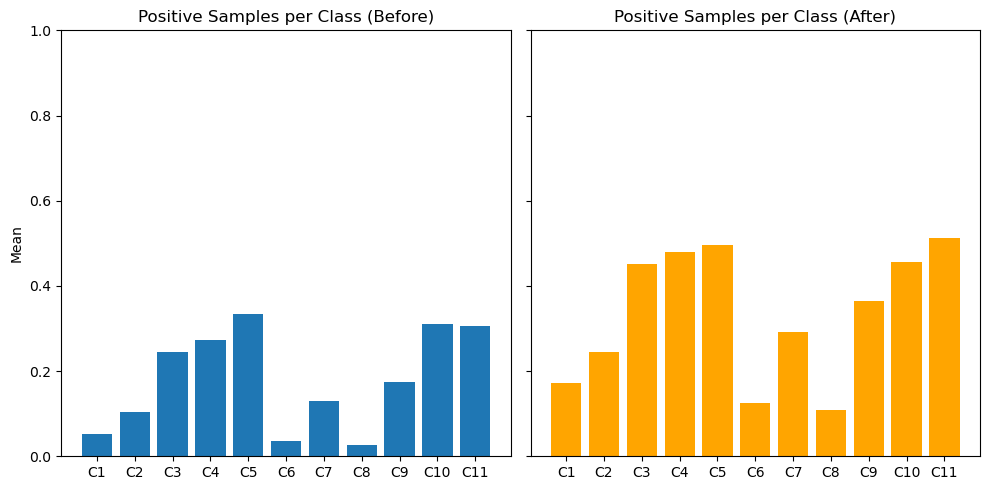

In [82]:
from collections import defaultdict
import numpy as np
import random
from skmultilearn.problem_transform import LabelPowerset
from sklearn.datasets import make_multilabel_classification

def distribute_remainder(r, r_dist, idx):
    p = len(r_dist) - idx + 1
    value = r // p
    curr_rem = r % p

    r_dist[idx:] = np.add(r_dist[idx:], value)
    
    if curr_rem > 0:
        start = len(r_dist) - curr_rem
        r_dist[start:] = np.add(r_dist[start:], 1)


def LP_RUS(y, samples_to_keep):
    total_samples = y.shape[0]
    samples_to_delete = total_samples - samples_to_keep
    if samples_to_delete <= 0:
        return list(range(total_samples))

    lp = LabelPowerset()
    labelsets = np.array(lp.transform(y))
    label_set_bags = defaultdict(list)
    for idx, label in enumerate(labelsets):
        label_set_bags[label].append(idx)

    # Sort label sets by size descending
    sorted_labels = sorted(label_set_bags.keys(), key=lambda l: len(label_set_bags[l]), reverse=True)

    del_samples = []
    # Iteratively remove samples from the largest sets until we've deleted exactly samples_to_delete
    for label in sorted_labels:
        if len(del_samples) == samples_to_delete:
            break
        # How many can we remove from this label without going below 0
        can_remove = min(len(label_set_bags[label]), samples_to_delete - len(del_samples))
        # Remove "can_remove" samples (no heuristic, just remove from front or randomly)
        for _ in range(can_remove):
            del_samples.append(label_set_bags[label].pop())

    # If we haven't reached the exact deletion count for some reason, try again or adjust logic
    # But if done carefully, it should match exactly.

    all_indices = set(range(total_samples))
    del_set = set(del_samples)
    keep_indices = all_indices - del_set
    return sorted(list(keep_indices))


# Example of usage:
x, y = make_multilabel_classification(n_samples=1000, n_features=10, n_classes=11)

print('Positive samples per class before:')
print(np.mean(y, axis=0))

# Choose how many samples to keep, e.g., keep 750 samples out of 1000
num_to_keep = 250
keep_idxs = LP_RUS(y, num_to_keep)

print('Number of samples to keep:')
print(len(keep_idxs))

print('Positive samples per class after keeping:')
print(np.mean(y[keep_idxs, :], axis=0))

# Plot the means before and after
x_labels = [f'C{i+1}' for i in range(y.shape[1])]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot before
axes[0].bar(x_labels, np.mean(y, axis=0))
axes[0].set_title('Positive Samples per Class (Before)')
axes[0].set_ylabel('Mean')
axes[0].set_ylim(0, 1)

# Plot after
axes[1].bar(x_labels, np.mean(y[keep_idxs, :], axis=0), color='orange')
axes[1].set_title('Positive Samples per Class (After)')

plt.tight_layout()
plt.show()



In [95]:
import torch

# Example: Assume `labels` is a 2D tensor with shape (num_samples, num_classes)
# Each entry is 0 or 1, indicating the absence or presence of a label.
labels = torch.tensor([[1, 0, 1], [0, 1, 0], [1, 1, 0], [0, 0, 1]])  # Example dataset

# Count positive and negative samples per label
num_samples = labels.size(0)
pos_counts = labels.sum(dim=0)  # Number of positive samples for each label
neg_counts = num_samples - pos_counts  # Number of negative samples for each label

# Compute positive weights
pos_weight = neg_counts / (pos_counts + 1e-8)  # Add epsilon to avoid division by zero
